In [1]:
import pandas as pd
import numpy as np
import random
import requests
import torch
import torch.nn as nn
import torch_geometric
from torch_geometric.data import Data
from sklearn.cluster import KMeans
from geopy.distance import great_circle
import networkx as nx
import matplotlib.pyplot as plt

c:\Users\tejas\OneDrive\Desktop\major_project\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def generate_random_customers(center_lat, center_lon, radius_km, num_customers):
    """Generate a DataFrame of random customer data within a certain radius."""
    
    def random_coordinates(center_lat, center_lon, radius_km):
        radius_in_degrees = radius_km / 111  # Approx. 111 km per degree latitude
        lat = center_lat + random.uniform(-radius_in_degrees, radius_in_degrees)
        lon = center_lon + random.uniform(-radius_in_degrees, radius_in_degrees)
        return lat, lon

    time_slots = ['9-11 AM', '10-12 AM', '1-3 PM', '2-4 PM', '4-6 PM']
    
    customer_data = {
        'customer_id': [i for i in range(1, num_customers + 1)],
        'latitude': [],
        'longitude': [],
        'preferred_time_slot': [random.choice(time_slots) for _ in range(num_customers)]
    }

    for _ in range(num_customers):
        lat, lon = random_coordinates(center_lat, center_lon, radius_km)
        customer_data['latitude'].append(lat)
        customer_data['longitude'].append(lon)

    return pd.DataFrame(customer_data)

# Define center point and radius
center_latitude = 28.6139  # Example: New Delhi
center_longitude = 77.2090
radius_kilometers = 10  # Radius in kilometers
num_customers = 100

# Generate random customer data
customers_df = generate_random_customers(center_latitude, center_longitude, radius_kilometers, num_customers)
print(customers_df.head())


   customer_id   latitude  longitude preferred_time_slot
0            1  28.538676  77.258410              4-6 PM
1            2  28.703856  77.292236              4-6 PM
2            3  28.643720  77.228774             9-11 AM
3            4  28.689824  77.195555              2-4 PM
4            5  28.549787  77.152147            10-12 AM


In [8]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Cluster customers based on timeslots and geographic coordinates
def cluster_customers(customers_df, num_clusters=5):
    clusters = {}
    for time_slot in customers_df['preferred_time_slot'].unique():
        # Create a copy of the DataFrame for each time slot to avoid SettingWithCopyWarning
        slot_customers = customers_df[customers_df['preferred_time_slot'] == time_slot].copy()
        
        # Fit KMeans on latitude and longitude
        kmeans = KMeans(n_clusters=min(num_clusters, len(slot_customers)), random_state=0)
        slot_customers['cluster'] = kmeans.fit_predict(slot_customers[['latitude', 'longitude']])

        clusters[time_slot] = slot_customers
    
    return clusters

# Cluster customers
clustered_customers = cluster_customers(customers_df)
for slot, df in clustered_customers.items():
    print(f"Time slot: {slot}, Clusters:\n{df.head()}")


Time slot: 4-6 PM, Clusters:
    customer_id   latitude  longitude preferred_time_slot  cluster
0             1  28.538676  77.258410              4-6 PM        2
1             2  28.703856  77.292236              4-6 PM        1
5             6  28.530211  77.133056              4-6 PM        0
10           11  28.674273  77.188510              4-6 PM        4
14           15  28.638851  77.285842              4-6 PM        1
Time slot: 9-11 AM, Clusters:
    customer_id   latitude  longitude preferred_time_slot  cluster
2             3  28.643720  77.228774             9-11 AM        0
13           14  28.696311  77.235621             9-11 AM        4
15           16  28.571794  77.139907             9-11 AM        3
19           20  28.554269  77.192686             9-11 AM        1
22           23  28.665402  77.230425             9-11 AM        0
Time slot: 2-4 PM, Clusters:
    customer_id   latitude  longitude preferred_time_slot  cluster
3             4  28.689824  77.195555    

In [9]:
# Assign delivery personnel to each cluster
def assign_delivery_personnel(clustered_customers):
    personnel_assigned = {}
    for time_slot, df in clustered_customers.items():
        df.loc[:,'delivery_personnel']= [f"Personnel_{cluster}" for cluster in df['cluster']].copy()
        personnel_assigned[time_slot] = df
    return personnel_assigned

# Assign delivery personnel to clusters
clustered_customers_with_personnel = assign_delivery_personnel(clustered_customers)
print(clustered_customers_with_personnel['9-11 AM'].head())


    customer_id   latitude  longitude preferred_time_slot  cluster  \
2             3  28.643720  77.228774             9-11 AM        0   
13           14  28.696311  77.235621             9-11 AM        4   
15           16  28.571794  77.139907             9-11 AM        3   
19           20  28.554269  77.192686             9-11 AM        1   
22           23  28.665402  77.230425             9-11 AM        0   

   delivery_personnel  
2         Personnel_0  
13        Personnel_4  
15        Personnel_3  
19        Personnel_1  
22        Personnel_0  


In [5]:
import networkx as nx
import requests

HERE_API_KEY = 'Ur5mcEt5nP9kQNySgZFeILZ6HyxBJmJOMHabtjorKVQ'

def get_distance_data(origin, destination):
    url = f"https://router.hereapi.com/v8/routes?transportMode=car&origin={origin}&destination={destination}&return=summary&apiKey={HERE_API_KEY}"
    try:
        response = requests.get(url)
        response.raise_for_status()
        return response.json()
    except Exception as e:
        print(f"Error: {e}")
        return None

# Create a graph for a chosen cluster
def create_graph_for_cluster(df):
    G = nx.Graph()
    for index, row in df.iterrows():
        G.add_node(f"Customer {row['customer_id']}", pos=(row['latitude'], row['longitude']))
    
    # Limit API calls to 150
    api_call_count = 0
    api_call_limit = 150
    
    for index_a, row_a in df.iterrows():
        for index_b, row_b in df.iterrows():
            if index_a != index_b and api_call_count < api_call_limit:
                origin = f"{row_a['latitude']},{row_a['longitude']}"
                destination = f"{row_b['latitude']},{row_b['longitude']}"
                travel_data = get_distance_data(origin, destination)
                
                if travel_data and 'routes' in travel_data and travel_data['routes']:
                    distance = travel_data['routes'][0]['sections'][0]['summary']['length'] / 1000
                    G.add_edge(f"Customer {row_a['customer_id']}", f"Customer {row_b['customer_id']}", weight=distance)
                    api_call_count += 1
    
    return G

# Choose a cluster (e.g., from the '9-11 AM' timeslot)
chosen_cluster = clustered_customers_with_personnel['9-11 AM'][clustered_customers_with_personnel['9-11 AM']['cluster'] == 0]
G = create_graph_for_cluster(chosen_cluster)


In [6]:
print(G.nodes())

['Customer 3', 'Customer 23', 'Customer 30', 'Customer 40', 'Customer 45', 'Customer 85', 'Customer 99']


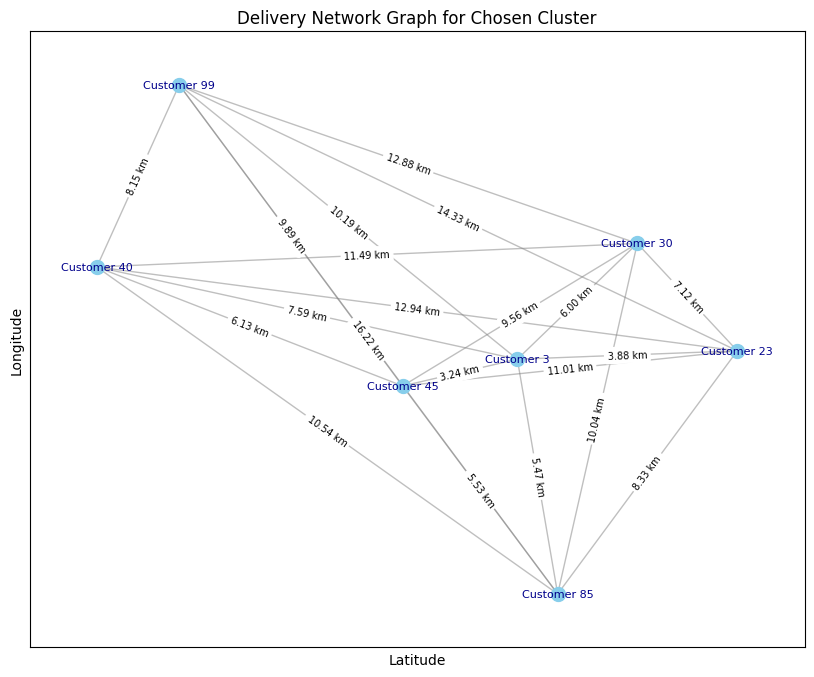

In [7]:
# Function to visualize the graph
def visualize_graph(G):
    # Get positions of nodes for plotting
    pos = nx.get_node_attributes(G, 'pos')
    
    # Draw nodes and edges
    plt.figure(figsize=(10, 8))
    nx.draw_networkx_nodes(G, pos, node_size=100, node_color='skyblue')
    nx.draw_networkx_edges(G, pos, width=1, alpha=0.5, edge_color='gray')
    nx.draw_networkx_labels(G, pos, font_size=8, font_color="darkblue")
    
    # Display edge weights (distances)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): f"{d:.2f} km" for u, v, d in G.edges(data='weight')}, font_size=7)
    
    plt.title("Delivery Network Graph for Chosen Cluster")
    plt.xlabel("Latitude")
    plt.ylabel("Longitude")
    plt.show()

# Choose a cluster (e.g., from the '9-11 AM' timeslot)
chosen_cluster = clustered_customers_with_personnel['9-11 AM'][clustered_customers_with_personnel['9-11 AM']['cluster'] == 0]
G = create_graph_for_cluster(chosen_cluster)

# Visualize the graph
visualize_graph(G)